# Time series forecasting
**V4: Autoregressive RNN**

A comparison between different prediction models

Based on: https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
import os
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython
import IPython.display

sns.set_theme()

### Import data

In [2]:
df = pd.read_pickle("..\data\data_prepared.pkl")
df.head()

,prod_wind,prod_solar,day_sin,day_cos,year_sin,year_cos,solar_el,solar_el_clip
datetime,,,,,,,,
2020-01-01 00:00:00+00:00,6989.50,0.0,-7.670342e-12,1.000000,-2.150345e-03,0.999998,-60.949049,0.0
2020-01-01 01:00:00+00:00,7371.25,0.0,2.588190e-01,0.965926,-1.433564e-03,0.999999,-56.073363,0.0
2020-01-01 02:00:00+00:00,7447.75,0.0,5.000000e-01,0.866025,-7.167823e-04,1.000000,-48.553549,0.0
2020-01-01 03:00:00+00:00,7699.25,0.0,7.071068e-01,0.707107,1.964387e-15,1.000000,-39.725411,0.0
2020-01-01 04:00:00+00:00,7703.00,0.0,8.660254e-01,0.500000,7.167823e-04,1.000000,-30.389395,0.0


### Split the data
- 70% training
- 20% validation
- 10% test

In [3]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
df_train = df[0:int(n*0.7)]
df_val = df[int(n*0.7):int(n*0.9)]
df_test = df[int(n*0.9):]

### Normalize the data

In [4]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
# fit scaler to training data
scaler.fit(df_train)
# scale all sets according to train set, preserve data frames
df_train = pd.DataFrame(scaler.transform(df_train),
                        columns=df.columns, index=df_train.index)
df_val = pd.DataFrame(scaler.transform(df_val),
                        columns=df.columns, index=df_val.index)
df_test = pd.DataFrame(scaler.transform(df_test),
                        columns=df.columns, index=df_test.index)

### Data Windowing
#### 1. Indexes and offsets

- Windows Generator that can create multiple inputs, one for the inputs that are only known in the past (power production) and one for inputs that are also known in the future (time and weather)

In [5]:
class WindowGenerator():
  def __init__(self, past_width, prediction_width,
               train_df=df_train, val_df=df_val, test_df=df_test,
               input_columns=None, time_columns=None, label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the column indices
    self.column_indices = {name: i for i, name in
                        enumerate(train_df.columns)}
    self.input_columns = input_columns
    if input_columns is not None:
      self.input_columns_indices = {name: i for i, name in
                                    enumerate(input_columns)}
    self.time_columns = time_columns
    if time_columns is not None:
      self.time_columns_indices = {name: i for i, name in
                                    enumerate(time_columns)}
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}


    # Work out the window parameters.
    self.past_width = past_width
    self.prediction_width = prediction_width

    self.total_window_size = past_width + prediction_width

    self.input_slice = slice(0, past_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.time_indices = np.arange(self.total_window_size)

    self.labels_slice = slice(self.past_width, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size:    {self.total_window_size}',
        f'Past input indices:   {self.input_indices}',
        f'Time input indices:   {self.time_indices}',
        f'Label indices:        {self.label_indices}',
        f'Input column name(s): {self.input_columns}',
        f'Time column name(s):  {self.time_columns}',
        f'Label column name(s): {self.label_columns}'])

##### 2. Split

In [6]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  if self.input_columns is not None:
    inputs = tf.stack(
        [inputs[:, :, self.column_indices[name]] for name in self.input_columns],
        axis=-1)
  time = features
  if self.time_columns is not None:
    time = tf.stack(
        [time[:, :, self.column_indices[name]] for name in self.time_columns],
        axis=-1)
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.past_width, None])
  time.set_shape([None, self.total_window_size, None])
  labels.set_shape([None, self.prediction_width, None])

  return inputs, time, labels

WindowGenerator.split_window = split_window

#### Testing the split window function

In [7]:
# Choose which feature to predict:
prediction_features = ["prod_wind", "prod_solar"]
num_features = len(prediction_features)

# Choose which feature contain time data and are available for the past and future
time_features = ["day_sin", "day_cos", "year_sin",
                 "year_cos", "solar_el", "solar_el_clip"]

# Choose which feature should be used as regular inputs, which are only available for the past
input_features = ["prod_wind", "prod_solar"]

PAST_STEPS = 24
PREDICTION_STEPS = 24

multi_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    past_width=PAST_STEPS, prediction_width=PREDICTION_STEPS,
    input_columns=input_features,
    time_columns=time_features,
    label_columns=prediction_features,
)

multi_window


Total window size:    48
Past input indices:   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Time input indices:   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices:        [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Input column name(s): ['prod_wind', 'prod_solar']
Time column name(s):  ['day_sin', 'day_cos', 'year_sin', 'year_cos', 'solar_el', 'solar_el_clip']
Label column name(s): ['prod_wind', 'prod_solar']

##### 3. Plot

In [19]:
def plot(self, model=None, plot_col="prod_solar", max_subplots=3):
  inputs, time, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xticks(np.arange(min(self.label_indices), max(self.label_indices)+1, 6))
  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

#### 4. Create `tf.data.Datasets`

In [10]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [11]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now, the `WindowGenerator` object gives you access to the tf.data.Dataset objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, data types, and shapes of the dataset elements.

In [12]:
multi_window.train.element_spec

(TensorSpec(shape=(None, 24, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 48, 6), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 24, 2), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [13]:
for example_inputs, example_time, example_labels in multi_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Time shape (batch, time, features):   {example_time.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 2)
Time shape (batch, time, features):   (32, 48, 6)
Labels shape (batch, time, features): (32, 24, 2)


Plot and example window

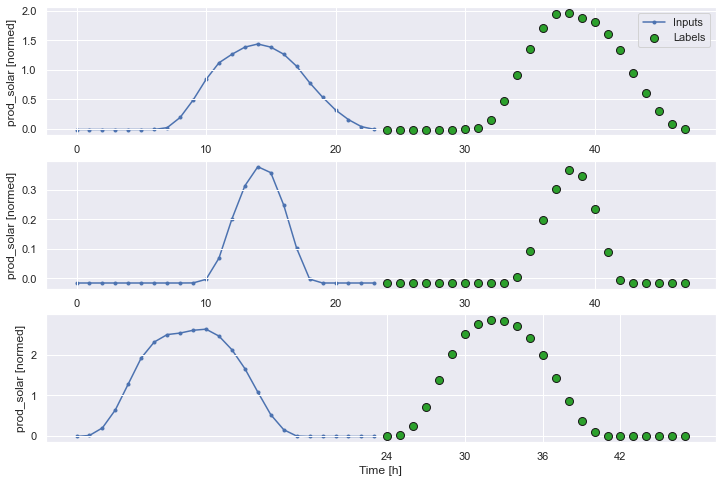

In [20]:
multi_window.plot(plot_col="prod_solar")
# multi_window.plot(plot_col="prod_wind")